<a href="https://colab.research.google.com/github/yeesem/Soft-Computing/blob/main/Alternative_Assessment_Handwriting_Recognization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import os
import tensorflow as tf

In [54]:
!git clone https://github.com/Walmond3/WIX3001-Alt-Ass

fatal: destination path 'WIX3001-Alt-Ass' already exists and is not an empty directory.


# Image Preprocessing

**Image Cropping**

In [55]:
def crop_image_into_pieces(image_path, output_folder, rows, columns, owner):
    # Open the image
    image = Image.open(image_path)

    # Convert image to RGB mode (remove alpha channel)
    image = image.convert("RGB")

    # Get the dimensions of the original image
    original_width, original_height = image.size

    # Calculate the width and height of each piece
    piece_width = original_width // columns
    piece_height = original_height // rows

    # Initialize a list to store data for each cropped image
    cropped_images_data = []

    # Iterate through each row and column
    for row in range(rows):
        for col in range(columns):
            # Calculate the coordinates for cropping
            left = col * piece_width
            upper = row * piece_height
            right = left + piece_width
            lower = upper + piece_height

            # Crop the image
            cropped_img = image.crop((left, upper, right, lower))

            # Invert the colors
            inverted_img = ImageOps.invert(cropped_img)

            # Create output subfolder if it doesn't exist
            os.makedirs(output_folder, exist_ok=True)

            # Save the cropped image
            output_filename = f"{owner}_crop_{row}_{col}.jpg"
            output_filepath = os.path.join(output_folder, output_filename)
            inverted_img.save(output_filepath)

            # Append data to the list for DataFrame
            cropped_images_data.append({
                "Filename": output_filename,
                "Filepath": output_filepath,
                "Owner": owner
            })
            # print(f"Saved {output_filename}")

    print(f"All crops for {owner} saved!")

    return cropped_images_data

# Directory where the images are stored
images_directory = "/content/WIX3001-Alt-Ass/Handwriting"

# Output folder to save cropped images within Colab
output_folder = "/content/output_crops"

# Number of rows and columns in the grid
rows = 12
columns = 12

# Check if the images directory exists
if not os.path.exists(images_directory):
    print(f"Error: {images_directory} does not exist.")
    exit()

# List all files in the images directory
image_files = os.listdir(images_directory)

# Check if there are any image files
if not image_files:
    print(f"No image files found in {images_directory}.")
    exit()

# Initialize a list to store all cropped images data
all_cropped_images_data = []

# Iterate through each image file
for image_file in image_files:
    image_path = os.path.join(images_directory, image_file)
    owner, _ = os.path.splitext(image_file)  # Get owner from filename without extension
    cropped_images_data = crop_image_into_pieces(image_path, output_folder, rows, columns, owner)

    # Testing
    all_cropped_images_data.extend(cropped_images_data)

All crops for Hui Yi saved!
All crops for Jin Khye saved!
All crops for Yan Ho saved!
All crops for Yan Hao saved!
All crops for Yee Sem saved!


**Store images in df**

In [56]:
# Create a DataFrame from the list of cropped images data
df = pd.DataFrame(all_cropped_images_data)
df.head()

,Filename,Filepath,Owner
0,Hui Yi_crop_0_0.jpg,/content/output_crops/Hui Yi_crop_0_0.jpg,Hui Yi
1,Hui Yi_crop_0_1.jpg,/content/output_crops/Hui Yi_crop_0_1.jpg,Hui Yi
2,Hui Yi_crop_0_2.jpg,/content/output_crops/Hui Yi_crop_0_2.jpg,Hui Yi
3,Hui Yi_crop_0_3.jpg,/content/output_crops/Hui Yi_crop_0_3.jpg,Hui Yi
4,Hui Yi_crop_0_4.jpg,/content/output_crops/Hui Yi_crop_0_4.jpg,Hui Yi


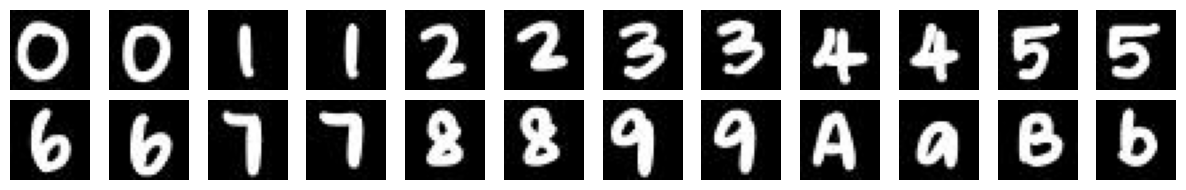

In [57]:
def display_images(filepaths):
    fig, axes = plt.subplots(len(filepaths) // columns, columns, figsize=(12, 2))
    for i, filepath in enumerate(filepaths):
        img = Image.open(filepath)
        ax = axes[i // columns, i % columns]
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# Display the images
display_images(df['Filepath'][:24])

**Split Dataset**

In [58]:
from sklearn.model_selection import train_test_split


train,test = train_test_split(df,test_size=0.1, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [95]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale = 1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_dataframe(
    train,
    x_col='Filepath',
    y_col = 'Owner',
    target_size = (150,150),
    class_mode = 'categorical'
)

Found 648 validated image filenames belonging to 5 classes.


# Transfer Learning

In [96]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-05-15 16:39:39--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.215.207, 173.194.216.207, 173.194.217.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.215.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  79.9MB/s    in 1.0s    

2024-05-15 16:39:40 (79.9 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [97]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = "/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Initialize the base model
# Set the input shape and remove the dense layer
pre_trained_model = InceptionV3(input_shape = (150,150,3),
                                include_top = False,
                                weights = None)

# Load the pre-trained weights
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers
for layer in pre_trained_model.layers:
  layer.trainable = False

In [98]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024,activation = 'relu')(x)
# Add Dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final softmax layer for classification
x = layers.Dense(5,activation = 'softmax')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input,x)

# Print the model summary
# model.summary()

In [94]:
model.compile(optimizer = RMSprop(learning_rate = 0.0001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

In [69]:
model.fit(
    train_generator,
    epochs = 15,
    batch_size = 32
)

Epoch 1/15
21/21 [==============================] - 13s 397ms/step - loss: 1.4437 - accuracy: 0.4444
Epoch 2/15
21/21 [==============================] - 7s 310ms/step - loss: 0.9682 - accuracy: 0.6265
Epoch 3/15
21/21 [==============================] - 13s 628ms/step - loss: 0.7800 - accuracy: 0.7083
Epoch 4/15
21/21 [==============================] - 14s 637ms/step - loss: 0.6822 - accuracy: 0.7593
Epoch 5/15
21/21 [==============================] - 7s 335ms/step - loss: 0.5845 - accuracy: 0.7994
Epoch 6/15
21/21 [==============================] - 10s 458ms/step - loss: 0.5260 - accuracy: 0.8241
Epoch 7/15
21/21 [==============================] - 8s 402ms/step - loss: 0.4573 - accuracy: 0.8472
Epoch 8/15
21/21 [==============================] - 6s 304ms/step - loss: 0.4137 - accuracy: 0.8642
Epoch 9/15
21/21 [==============================] - 8s 400ms/step - loss: 0.3771 - accuracy: 0.8843
Epoch 10/15
21/21 [==============================] - 7s 329ms/step - loss: 0.3163 - accuracy: 0.

In [70]:
class_names = list(df["Owner"].unique())
class_names

['Hui Yi', 'Jin Khye', 'Yan Ho', 'Yan Hao', 'Yee Sem']

Found 72 validated image filenames belonging to 5 classes.
1/1 [==============================] - 0s 427ms/step


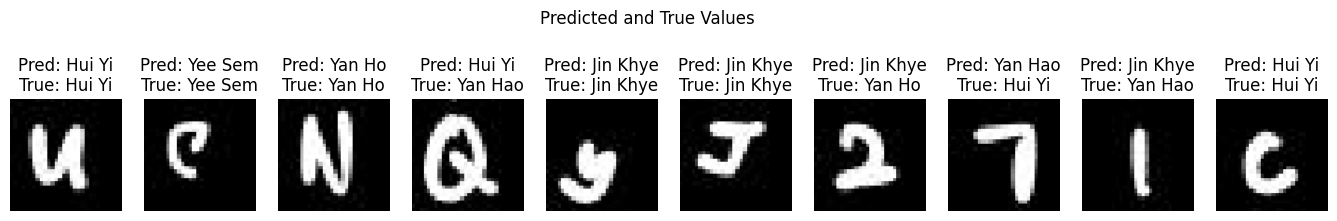

In [91]:
def display_images(images, predictions, labels, title, n):
    fig, axes = plt.subplots(1, n, figsize=(17, 3))
    fig.suptitle(title)

    for i in range(n):
        axes[i].imshow(images[i])
        axes[i].set_title(f"Pred: {predictions[i]}\nTrue: {labels[i]}")
        axes[i].axis('off')

    plt.show()

# All images will be rescaled by 1./255
test_datagen = ImageDataGenerator(rescale = 1/255)

# Flow training images in batches of 128 using train_datagen generator
test_generator = test_datagen.flow_from_dataframe(
    test,
    x_col='Filepath',
    y_col = 'Owner',
    target_size = (75,75),
    class_mode = 'categorical'
)

x_batches, y_pred_batches, y_true_batches = [], [], []

for x, y in test_generator:
    y_pred = model.predict(x)
    y_pred_batches.append(y_pred)
    y_true_batches.append(y)
    x_batches.append(x)

    if len(y_pred_batches) >= 10:  # Stopping condition: display 10 images
        break

x_batches = np.concatenate(x_batches)
y_pred_batches = np.concatenate(y_pred_batches)
y_true_batches = np.concatenate(y_true_batches)

indexes = np.random.choice(len(y_pred_batches), size=10)
images_to_plot = x_batches[indexes]
y_pred_to_plot = y_pred_batches[indexes]
y_true_to_plot = y_true_batches[indexes]

y_pred_labels = [class_names[np.argmax(sel_y_pred)] for sel_y_pred in y_pred_to_plot]
y_true_labels = [class_names[np.argmax(sel_y_true)] for sel_y_true in y_true_to_plot]
display_images(images_to_plot, y_pred_labels, y_true_labels, "Predicted and True Values", 10)